Rows: 120 Columns: 31
── Column specification ────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (10): Sample ID, Site, Date, Type, Type2, Index-notes, ICP-notes, IC-no...
dbl  (20): Fe_mg_L, Mn_mg_L, Cu_mg_L, Zn_mg_L, Si_mg_L, K_mg_L, P_mg_L, Mg_m...
time  (1): Time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


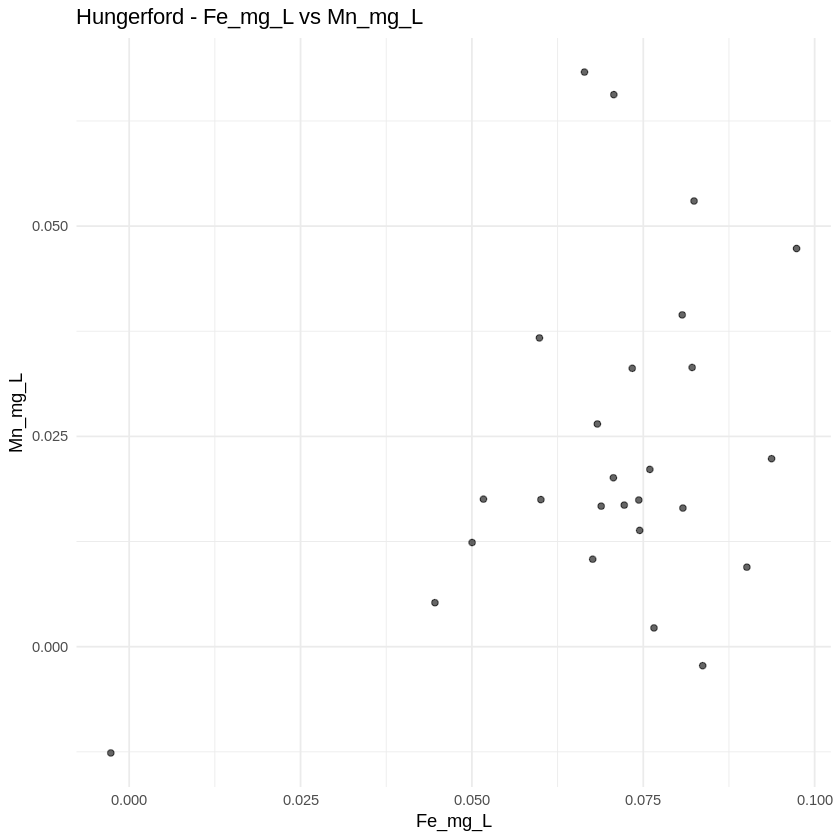

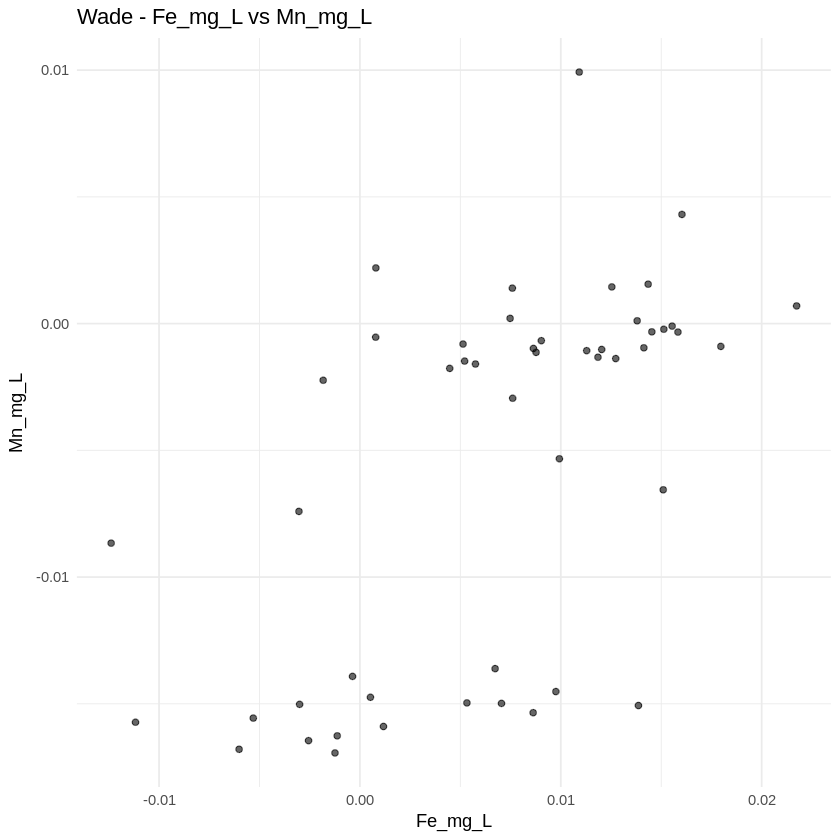

In [52]:
# Load required libraries
library(tidyverse)
library(lubridate)
library(rlang)
library(patchwork)

#Set working directory and bivariate plot output dir
setwd("~//OneDrive/git-repos/EMMA")
output_dir <- ("~//OneDrive/git-repos/EMMA/EMMA/EMMAs-R/bivariate_plots/")

# Read the CSV file
data <- read_csv("isco_metadata/LCBP_RI_sample_index/RI23-IC-ICP-isotope-joined.csv")

# Filter to streamwater samples
data <- data %>%
  filter(Type %in% c("Grab", "Grab/Isco", "Baseflow"))

# List of solute columns
solutes <- c('Fe_mg_L','Mn_mg_L','Cu_mg_L','Zn_mg_L','Si_mg_L',
 'K_mg_L','P_mg_L','Mg_mg_L','Na_mg_L','Al_mg_L','Ca_mg_L','Fl_mg_L','Cl_mg_L',
 'NO2_mg_L','Br_mg_L','NO3_mg_L','PO4_mg_L','SO4_mg_L', 'dD', 'd18O')

# Convert Date to proper date format and extract month
data <- data %>%
  mutate(Date = mdy(Date),
         Month = month(Date))

# Define custom season colors
season_colors <- c(
  "1" = "blue", "2" = "blue", "3" = "green", "4" = "green", "5" = "green",
  "6" = "red", "7" = "red", "8" = "red", "9" = "saddlebrown", "10" = "saddlebrown",
  "11" = "blue", "12" = "blue"
)

# Add color column based on month
data <- data %>%
  mutate(SeasonColor = season_colors[as.character(Month)])

# Split dataset by site
hungerford_data <- data %>% filter(Site == "Hungerford")
wade_data <- data %>% filter(Site == "Wade")

#########################################
# FUNCTION FOR PAIRWISE BIVARIATE PLOTS #
#########################################

plot_all_pairs_pairwise <- function(df, solutes, site_name, save = FALSE, out_dir = output_dir) {
  
  out_dir <- path.expand("~//OneDrive/git-repos/EMMA/EMMA/EMMAs-R/bivariate_plots/") 

  if (save && !dir.exists(out_dir)) {
    dir.create(out_dir, recursive = TRUE)
  }

  plot_list <- list()
  counter <- 1
  
  for (i in seq_along(solutes)) {
    for (j in seq_along(solutes)) {
      if (i < j) {
        x_var <- sym(solutes[i])
        y_var <- sym(solutes[j])
        pair_df <- df |> drop_na(!!x_var, !!y_var)
        if (nrow(pair_df) == 0) next

        p <- ggplot(pair_df, aes(x = !!x_var, y = !!y_var)) +
          geom_point(alpha = 0.6) +
          labs(
            title = paste(site_name, "-", solutes[i], "vs", solutes[j]),
            x = solutes[i],
            y = solutes[j]
          ) +
          theme_minimal()

        if (save) {
          ggsave(
            filename = file.path(out_dir, paste0(site_name, "_", solutes[i], "_vs_", solutes[j], ".png")),
            plot = p, width = 6, height = 4
          )
        } else {
          plot_list[[counter]] <- p
          counter <- counter + 1
        }
      }
    }
  }

  if (!save && length(plot_list) > 0) return(plot_list)
}

######################
# RUN FOR BOTH SITES # 
######################

hungerford_plots <- plot_all_pairs_pairwise(hungerford_data, solutes, "Hungerford")
wade_plots <- plot_all_pairs_pairwise(wade_data, solutes, "Wade")
plot_all_pairs_pairwise(hungerford_data, solutes, "Hungerford", save = TRUE, out_dir = output_dir)
plot_all_pairs_pairwise(wade_data, solutes, "Wade", save = TRUE, out_dir = output_dir)

######################
# PLOT SOME EXAMPLES #
######################

hungerford_plots[[1]]

wade_plots[[1]]

######################################
# COMPUTE PEARSON CORRELATION MATRIX #
######################################

# Function to compute Pearson's correlation matrix with pairwise complete observations
# Pearson's correlation matrix will become Table S1 of Winter 2023 EMMA paper
cor_matrix <- function(df, solutes) {
  df |>
    select(all_of(solutes)) |>
    cor(use = "pairwise.complete.obs", method = "pearson")
}

# Run Pearson's correlation matrix function for each site
hungerford_cor <- cor_matrix(hungerford_data, solutes)
wade_cor <- cor_matrix(wade_data, solutes)

# Function to extract high correlation pairs for the Pearson's
# MED set to 0.75 - Addie, feel free to change
get_high_corr_pairs <- function(cor_mat, threshold = 0.75) {
  cor_df <- as.data.frame(as.table(cor_mat))
  names(cor_df) <- c("var1", "var2", "cor")
  
  # Keep only upper triangle and filter by abs(cor) ≥ threshold
  cor_df <- cor_df |>
    filter(as.character(var1) < as.character(var2)) |>
    filter(abs(cor) >= threshold)
  
  return(cor_df)
}

# Run function to get high-correlation pairs
# Option to save
# MED notes we have an artefact of single-measurement Br data leading to R2 = 1 for all Br pairwise comparisons
hf_corr_pairs <- get_high_corr_pairs(hungerford_cor)
wd_corr_pairs <- get_high_corr_pairs(wade_cor)

plot_selected_pairs <- function(df, corr_df, site_name, save = FALSE, out_dir = output_dir) {
  
  out_dir <- path.expand(out_dir)
  if (save && !dir.exists(out_dir)) dir.create(out_dir, recursive = TRUE)
  
  plot_list <- list()
  counter <- 1
  
  for (k in seq_len(nrow(corr_df))) {
    x_var <- sym(corr_df$var1[k])
    y_var <- sym(corr_df$var2[k])
    pair_df <- df |> drop_na(!!x_var, !!y_var)
    if (nrow(pair_df) == 0) next

    p <- ggplot(pair_df, aes(x = !!x_var, y = !!y_var)) +
      geom_point(alpha = 0.6) +
      labs(
        title = paste(site_name, "-", corr_df$var1[k], "vs", corr_df$var2[k],
                      "\nPearson r =", round(corr_df$cor[k], 2)),
        x = corr_df$var1[k],
        y = corr_df$var2[k]
      ) +
      theme_minimal()
    
    if (save) {
      ggsave(
        filename = file.path(out_dir, paste0(site_name, "_", corr_df$var1[k], "_vs_", corr_df$var2[k], ".png")),
        plot = p, width = 6, height = 4
      )
    } else {
      plot_list[[counter]] <- p
      counter <- counter + 1
    }
  }
  
  if (!save && length(plot_list) > 0) return(plot_list)
}

# Plot high correlation pairs for each site

#hf_plots_highcorr <- plot_selected_pairs(hungerford_data, hf_corr_pairs, "Hungerford_highcorr", save = TRUE)
#wd_plots_highcorr <- plot_selected_pairs(wade_data, wd_corr_pairs, "Wade_highcorr", save = TRUE)

write.csv(hungerford_cor,file = file.path(output_dir, "Hungerford_2023_correlation_matrix.csv"))
write.csv(wade_cor,file = file.path(output_dir, "Wade_2023_correlation_matrix.csv"))